<a href="https://colab.research.google.com/github/miftakhlaziz/Detection_Covid-19_Convolutional_Neural_Networks_and_X-Rays_Images/blob/master/CNN_Detect_Covid_19_With_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library TensorFlow and Others

In [1]:
import argparse
import random
import os
import cv2
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19,VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
 
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)
print("GPU", "available (True)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.2.0-rc3
TF Hub version: 0.8.0
GPU available (True)


Mount and Import Dataset From Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

root_dir = "/content/gdrive/My Drive/"
training_base_dir = root_dir + "/Colab Notebooks/TensorFlow Detection Covid-19 X-Ray Image - Deep Learning/Dataset/Training/"
testing_base_dir = root_dir + "/Colab Notebooks/TensorFlow Detection Covid-19 X-Ray Image - Deep Learning/Dataset/Testing/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Convert Image Path to List

In [0]:
train_image_path = paths.list_images(training_base_dir)
train_image_path = sorted(train_image_path)

test_image_path = paths.list_images(testing_base_dir)
test_image_path = sorted(test_image_path)

Add Image Path to List

In [0]:
data = []
labels = []

for trainPath in train_image_path:
    label = trainPath.split(os.path.sep)[-2]
    image = cv2.imread(trainPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    data.append(image)
    labels.append(label)

data = np.array(data) / 255.0
labels = np.array(labels)

In [0]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

Initialize Learning Rate, Epochs, Batch Size, and Data Augmentation

In [6]:
INIT_LearningRate = 1e-3
Epochs = 25
Batch_Size = 8

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

train_datagen = ImageDataGenerator(rotation_range = 15, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(testing_base_dir,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = 2,seed=42,
    class_mode="categorical",
    shuffle = False)

# Add CNN architecture VGG16
build_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

Found 40 images belonging to 2 classes.
58892288/58889256 [==============================] - 0s 0us/step


Create CNN Model

In [7]:
# create model
CNN_model = build_model.output
CNN_model = AveragePooling2D(pool_size=(4, 4))(CNN_model)
CNN_model = Flatten(name="flatten")(CNN_model)
CNN_model = Dense(64, activation="relu")(CNN_model)
CNN_model = Dropout(0.5)(CNN_model)
CNN_model = Dense(2, activation="softmax")(CNN_model)

model = Model(inputs=build_model.input, outputs=CNN_model)

for layer in build_model.layers:
    layer.trainable = False

# compile our model
print("Compiling CNN model...")
Optimize = Adam(lr=INIT_LearningRate, decay=INIT_LearningRate / Epochs)
model.compile(loss="binary_crossentropy", optimizer=Optimize, metrics=["accuracy"])

# model summary
model.summary()

Compiling CNN model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56

Training Model CNN

In [8]:
print("Training CNN model...")
Train = model.fit(
    train_datagen.flow(trainX, trainY, batch_size=Batch_Size),
    steps_per_epoch=len(trainX) // Batch_Size,
    validation_data=(testX, testY),
    validation_steps=len(testX) // Batch_Size,
    epochs=Epochs)

Training CNN model...
Epoch 1/25
24/24 [==============================] - 3s 109ms/step - loss: 0.6896 - accuracy: 0.6198 - val_loss: 0.4632 - val_accuracy: 0.8958
Epoch 2/25
24/24 [==============================] - 2s 102ms/step - loss: 0.4592 - accuracy: 0.7865 - val_loss: 0.3634 - val_accuracy: 0.9375
Epoch 3/25
24/24 [==============================] - 2s 101ms/step - loss: 0.3654 - accuracy: 0.8958 - val_loss: 0.2639 - val_accuracy: 1.0000
Epoch 4/25
24/24 [==============================] - 2s 102ms/step - loss: 0.2957 - accuracy: 0.9010 - val_loss: 0.1928 - val_accuracy: 0.9583
Epoch 5/25
24/24 [==============================] - 2s 102ms/step - loss: 0.2435 - accuracy: 0.9427 - val_loss: 0.1573 - val_accuracy: 1.0000
Epoch 6/25
24/24 [==============================] - 2s 101ms/step - loss: 0.2036 - accuracy: 0.9479 - val_loss: 0.1395 - val_accuracy: 1.0000
Epoch 7/25
24/24 [==============================] - 2s 101ms/step - loss: 0.1631 - accuracy: 0.9688 - val_loss: 0.1047 - val_a

Initialize auth with GDrive

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

Save model to Google Drive

In [0]:
model.save('model_covid-19.h5')
model_file = drive.CreateFile({'title' : 'model_covid-19.h5'})
model_file.SetContentFile('model_covid-19.h5')
model_file.Upload()

Visualization model training

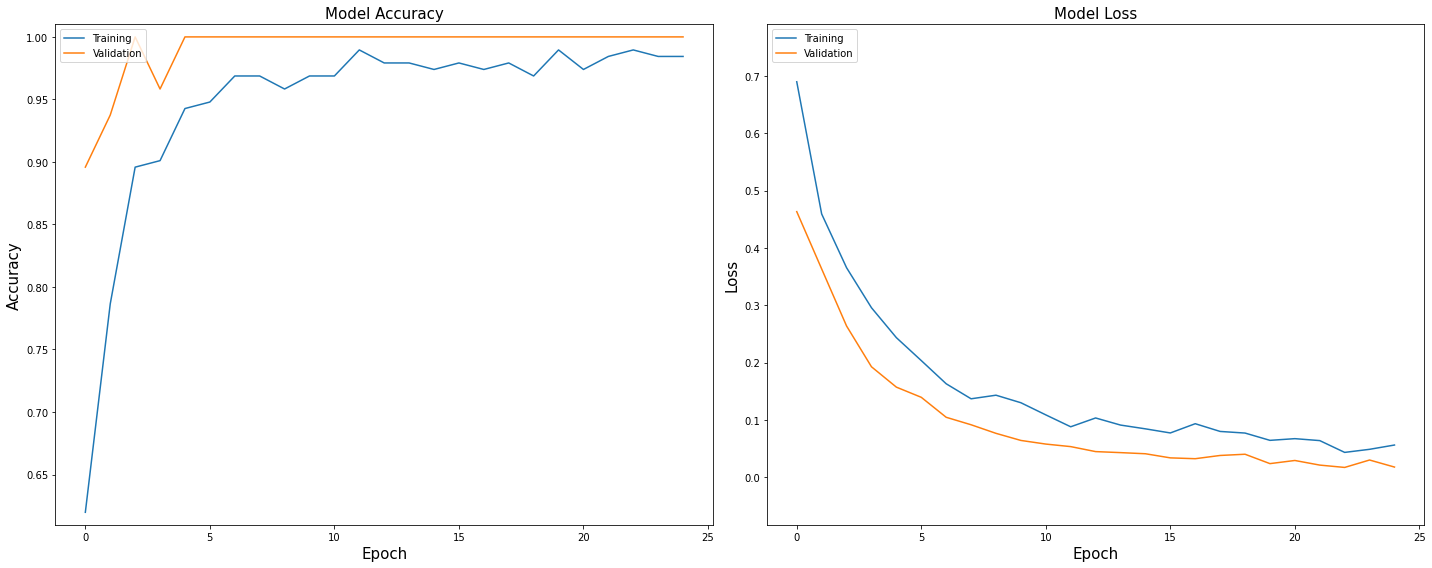

In [11]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]
plt.figure(figsize=(20, 8))

# Plot training & validation Accuracy values
y1 = Train.history['accuracy']
y2 = Train.history['val_accuracy']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]

plt.subplot(121)
plt.plot(y1)
plt.plot(y2)
# plt.style.use("seaborn-colorblind")
plt.title('Model Accuracy', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.tight_layout()  
                         
# Plot training & validation loss values
y1 = Train.history['loss']
y2 = Train.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
plt.subplot(122)
plt.plot(y1)
plt.plot(y2)
# plt.style.use("seaborn-colorblind")
plt.title('Model Loss', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')

plt.tight_layout()                  
plt.show()

Evaluate Model

In [12]:
print("results evaluate model")
result  = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results evaluate model
20/20 [==============================] - 15s 738ms/step - loss: 0.0224 - accuracy: 1.0000
Loss     : 0.02  
Accuracy : 100.00%


Confusion Matrix

20/20 - 1s
Result Confusion Matrix
------------------------------------------------------------------------------------------
Accuracy:  90.0 %
Precision:  90.0 %
Recall:  90.0 %
f1:  90.0 %


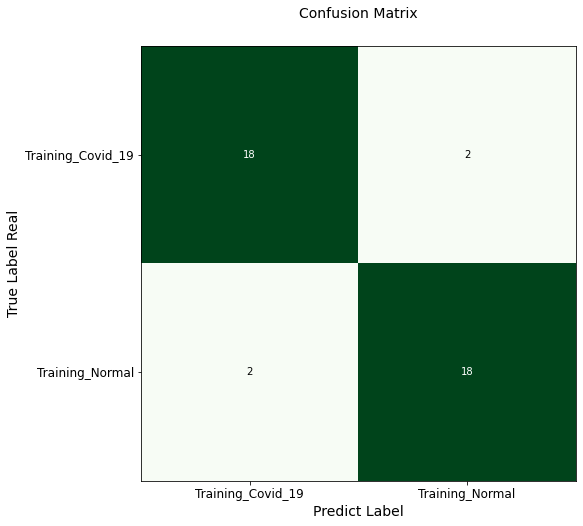

Sensitivity: 90.00%
Specificity: 90.00%


                   precision    recall  f1-score   support

Training_Covid_19       0.90      0.90      0.90        20
  Training_Normal       0.90      0.90      0.90        20

         accuracy                           0.90        40
        macro avg       0.90      0.90      0.90        40
     weighted avg       0.90      0.90      0.90        40



In [13]:
# evaluate the model
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
y_true = test_generator.classes
predictions = model.predict(test_generator, steps=len(test_generator), verbose=2)
predicted_classes = np.argmax(predictions,axis=1)

def scores(y_true,y_pred):
  accuracy = accuracy_score(y_true,y_pred)
  precision = precision_score(y_true,y_pred,average='macro')
  recall = recall_score(y_true,y_pred,average='macro')
  f1 = f1_score(y_true,y_pred,average='macro')
  confusionmatrix = confusion_matrix(y_true, y_pred)
  print("="*90)
  print("Result Confusion Matrix")
  print("-"*90)
  print("Accuracy: ", accuracy*100, "%")
  print("Precision: ", precision*100, "%")
  print("Recall: ", recall*100, "%")
  print("f1: ", f1*100, "%")
  # print("Accuracy:  {}".format(accuracy))
  # print("Precision: {}".format(precision))
  # print("Recall:    {}".format(recall))
  # print("F1:        {}".format(f1))
  print("="*90)
  # print("Confusion matrix:\n{}".format(confusionmatrix))

  fig, ax = plot_confusion_matrix(conf_mat=confusionmatrix ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Greens)
  plt.xticks(range(len(lb.classes_)), lb.classes_, fontsize=12)
  plt.yticks(range(len(lb.classes_)), lb.classes_, fontsize=12)
  plt.title("Confusion Matrix", fontsize=14)
  plt.ylabel('True Label Real',fontsize=14)
  plt.xlabel('Predict Label',fontsize=14)
  plt.show()

  cls_report_print = classification_report(y_true, y_pred, target_names=lb.classes_)
  cls_report = classification_report(y_true, y_pred, target_names=lb.classes_, output_dict=True)
  total1=sum(sum(confusionmatrix))

  ##### From confusion matrix calculate accuracy
  print("="*90)
  sensitivity1 = confusionmatrix[0,0]/(confusionmatrix[0,0]+confusionmatrix[0,1])
  print("%s%.2f%s"% ("Sensitivity: ", sensitivity1*100, "%"))
  specificity1 = confusionmatrix[1,1]/(confusionmatrix[1,0]+confusionmatrix[1,1])
  print("%s%.2f%s"% ("Specificity: ", specificity1*100, "%"))

  print("\n")
  print("="*90)
  # print("Report for Model File: ", model_title)
  print("="*90)
  print(cls_report_print)
  print("="*90)

scores(y_true,predicted_classes)


Initialize model for predictions dataset testing and visualization

In [14]:
preds = model.predict(test_generator,steps=1000,verbose=2)

1000/1000 - 68s


Predictions finished
Output Predictions From Data Testing : 


probability:[9.9907875e-01 9.2121243e-04]


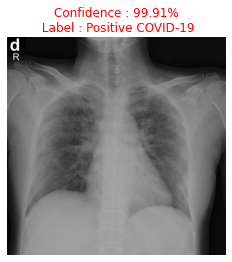



probability:[0.9988329  0.00116712]


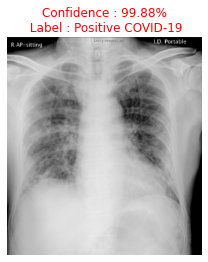



probability:[0.98889226 0.01110776]


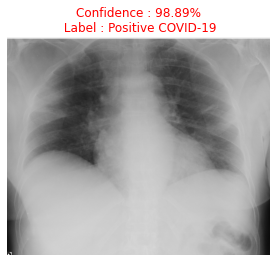



probability:[0.99835724 0.00164269]


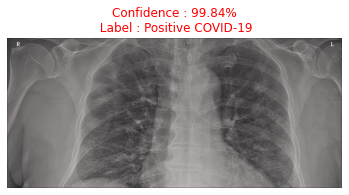



probability:[0.998139   0.00186095]


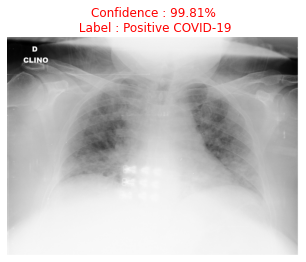



probability:[0.97442865 0.02557131]


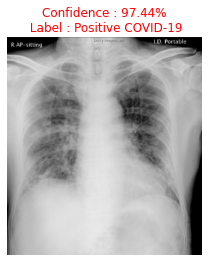



probability:[0.9782518  0.02174825]


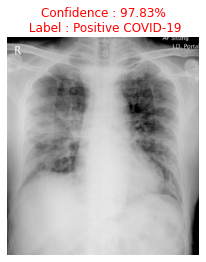



probability:[0.9918717 0.0081283]


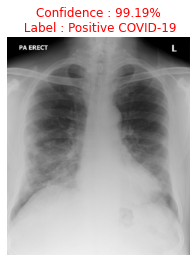



probability:[9.9986100e-01 1.3895721e-04]


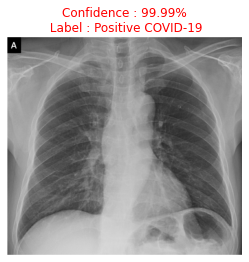



probability:[0.99188095 0.00811902]


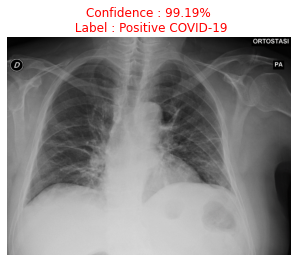



probability:[0.9943457  0.00565425]


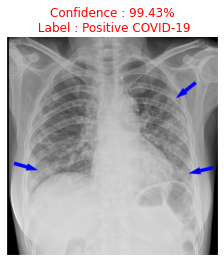



probability:[0.9782518  0.02174825]


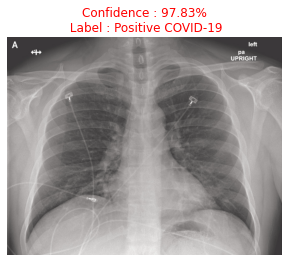



probability:[0.9989446  0.00105538]


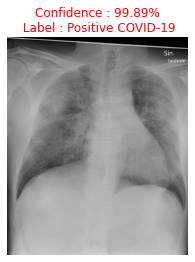



probability:[0.998139   0.00186095]


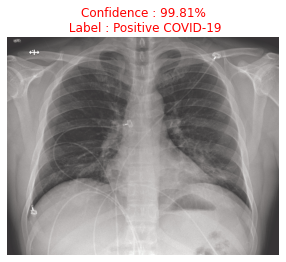



probability:[0.99835724 0.00164269]


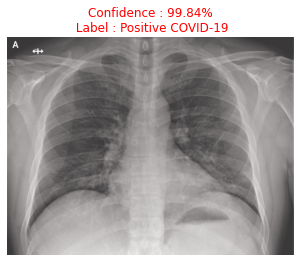



probability:[0.98889226 0.01110776]


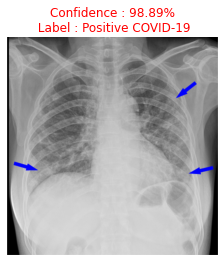



probability:[0.01023613 0.98976386]


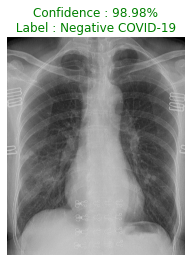



probability:[0.00191836 0.9980817 ]


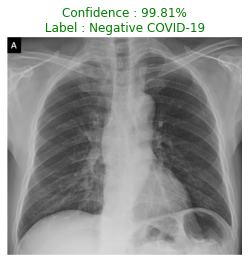



probability:[6.415019e-04 9.993585e-01]


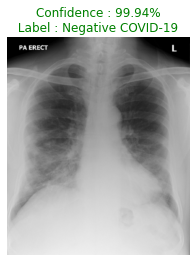



probability:[2.9252152e-04 9.9970740e-01]


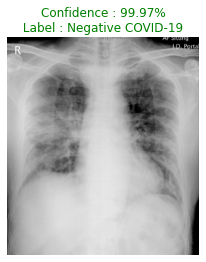



probability:[0.43852866 0.56147134]


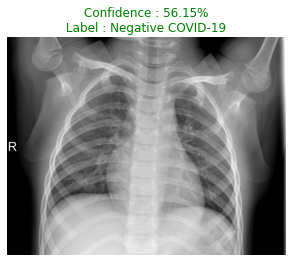



probability:[4.019513e-04 9.995981e-01]


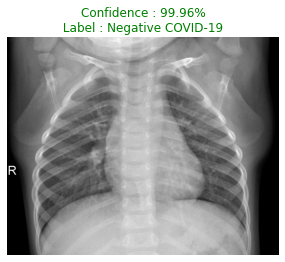



probability:[0.00192392 0.9980761 ]


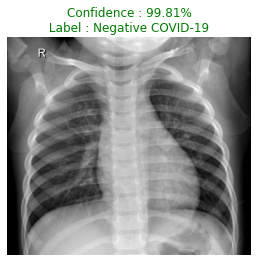



probability:[0.01089294 0.9891071 ]


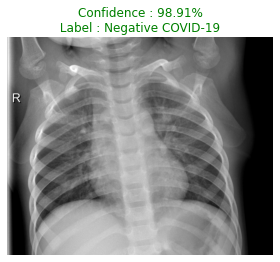



probability:[0.00773264 0.9922673 ]


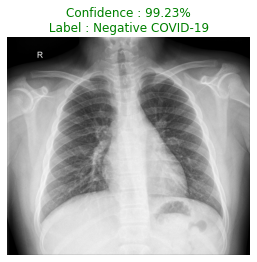



probability:[0.0047305 0.9952695]


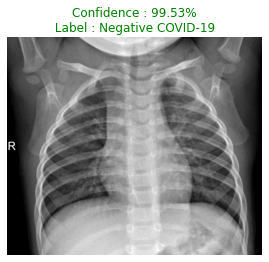



probability:[0.00184892 0.998151  ]


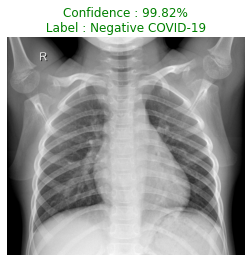



probability:[0.03097713 0.96902287]


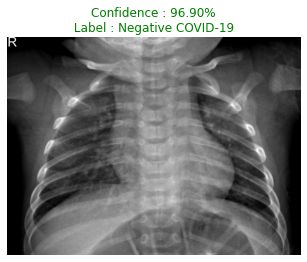



probability:[0.06791953 0.9320805 ]


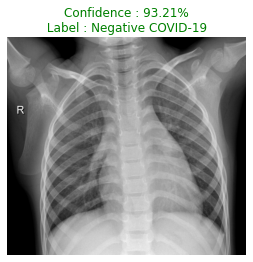



probability:[6.3022546e-04 9.9936980e-01]


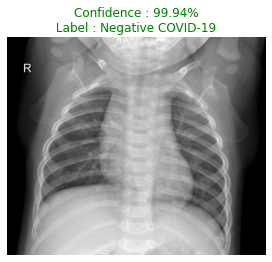



probability:[2.8043921e-04 9.9971956e-01]


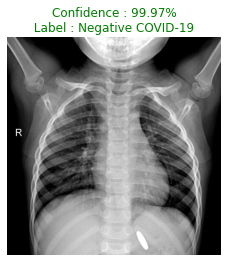



probability:[0.00789511 0.9921049 ]


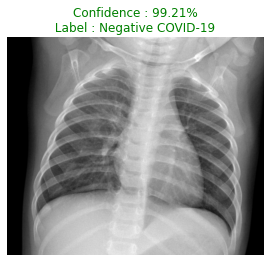



probability:[0.00572199 0.99427795]


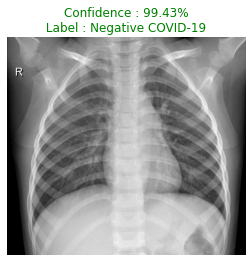



probability:[0.00459963 0.99540037]


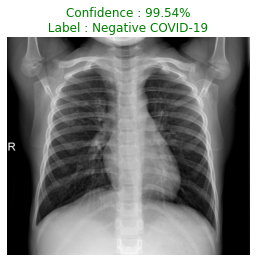



probability:[0.00171109 0.9982889 ]


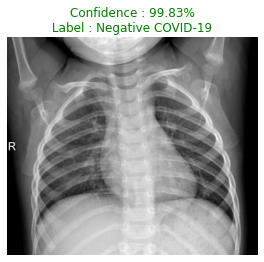



probability:[0.00524343 0.9947566 ]


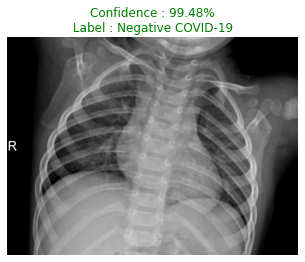



probability:[0.99682885 0.00317115]


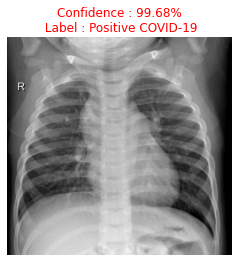



probability:[0.9988329  0.00116712]


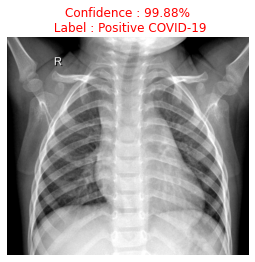



probability:[0.9986652  0.00133474]


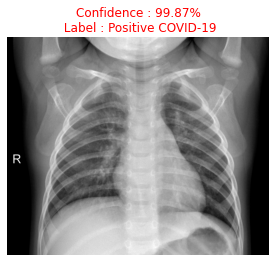



probability:[0.98194087 0.01805912]


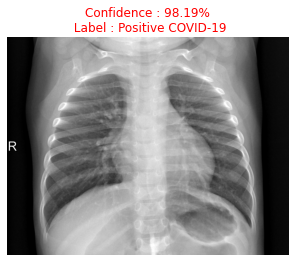

In [15]:
print("Predictions finished")
print("Output Predictions From Data Testing : ")
import cv2
import matplotlib.image as mpimg
try:
    for index, probability in enumerate (preds):
        image_path = testing_base_dir + "/" +test_generator.filenames[index]
        image = mpimg.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.axis('off')
        plt.imshow(image)

        print("\n\n============================================")
        
        # print(test_generator.filenames[index])
        # print("------------------------------")
        negative_color = 'green'
        positive_color = 'red'

        if probability[1] > 0.5:
          plt.title('Confidence : '+ '%.2f' % (probability[1]*100) +'%'+ '\n Label : Negative COVID-19 ',color=negative_color)
        else:
          plt.title('Confidence : '+ '%.2f' % ((1-probability[1])*100) +'%'+ '\n Label : Positive COVID-19',color=positive_color)

        print("probability:{}".format(probability))
        print("============================================")
        plt.show()
        print("============================================")
except IndexError:
    pass